### NSGA-2

In [1]:
#Importing required modules
import math
import random
import numpy as np
import matplotlib.pyplot as plt

# PMV
from pythermalcomfort.models import pmv_ppd
from pythermalcomfort.utilities import v_relative, clo_dynamic


### 1. Functions: NSGA-2 and PMV

### 1.1 Functions: NSGA-2 

In [2]:
#Function to find index of list
def index_of(a,list):
    for i in range(0,len(list)):
        if list[i] == a:
            return i
    return -1

#Function to sort by values
def sort_by_values(list1, values):
    sorted_list = []
    while(len(sorted_list)!=len(list1)):
        if index_of(min(values),values) in list1:
            sorted_list.append(index_of(min(values),values))
        values[index_of(min(values),values)] = math.inf
    return sorted_list



#Function to carry out NSGA-II's fast non dominated sort
def fast_non_dominated_sort(values1, values2):
    S=[[] for i in range(0,len(values1))]
    front = [[]]
    n=[0 for i in range(0,len(values1))]
    rank = [0 for i in range(0, len(values1))]

    for p in range(0,len(values1)):
        S[p]=[]
        n[p]=0
        for q in range(0, len(values1)):
            if (values1[p] > values1[q] and values2[p] > values2[q]) or (values1[p] >= values1[q] and values2[p] > values2[q]) or (values1[p] > values1[q] and values2[p] >= values2[q]):
                if q not in S[p]:
                    S[p].append(q)
            elif (values1[q] > values1[p] and values2[q] > values2[p]) or (values1[q] >= values1[p] and values2[q] > values2[p]) or (values1[q] > values1[p] and values2[q] >= values2[p]):
                n[p] = n[p] + 1
        if n[p]==0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)

    i = 0
    while(front[i] != []):
        Q=[]
        for p in front[i]:
            for q in S[p]:
                n[q] =n[q] - 1
                if( n[q]==0):
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i = i+1
        front.append(Q)

    del front[len(front)-1]
    return front



#Function to calculate crowding distance
def crowding_distance(values1, values2, front):
    distance = [0 for i in range(0,len(front))]
    sorted1 = sort_by_values(front, values1[:])
    sorted2 = sort_by_values(front, values2[:])
    distance[0] = 1234567890
    distance[len(front) - 1] = 1234567890
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted1[k+1]] - values2[sorted1[k-1]])/(max(values1)-min(values1))
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted2[k+1]] - values2[sorted2[k-1]])/(max(values2)-min(values2))
    return distance



#Function to carry out the crossover
def mutation(x):

    flag = 0
    while flag == 0:

        index_minus = random.randint(0,len(x)-1)
        index_add = random.randint(0,len(x)-1)
        
        if index_minus == index_add:
            if index_minus <= ((len(x)-1)/2):
                index_minus = index_minus + 1
            else:
                index_minus = index_minus - 1
        
        
        x_temp = int(x[index_minus]*random.random())
        if x_temp == 0:
            pass
        elif x_temp > 0:
            x[index_minus] = x[index_minus] - x_temp
            x[index_add] = x[index_add] + x_temp
            flag = 1
    
    check_0_x_r(x)
    
    return x

### 1.2 Function: PMV

In [3]:
def PMV(air_temperature, mean_radiant_temperature, relative_humidity, 
        air_speed, metabolic_rate, clothing_insulation):

    if mean_radiant_temperature != air_temperature:
        mean_radiant_temperature = air_temperature
        
    # calculate relative air speed
    relative_air_speed = v_relative(v=air_speed, met=metabolic_rate)

    # calculate dynamic clothing
    clo_d = clo_dynamic(clo=clothing_insulation, met=metabolic_rate)

    result = pmv_ppd(tdb = air_temperature, tr = mean_radiant_temperature, vr = relative_air_speed, 
                     rh = relative_humidity, met = metabolic_rate, clo = clo_d)
    
    
    return result['pmv']
    

### 2. Objective functions and related parameters

### 2.1 Related parameters

In [4]:
# Maximum capacity of areas
def area_max_capacity( ):
    
    r1 = 22
    r2 = 29
    r3 = 22
    r4 = 29
    r5 = 12
    r6 = 15
    r7 = 10
    result = [r1,r2,r3,r4,r5,r6,r7]
    return result

### 2.2 Objective functions

In [5]:
#First function (f_cost) to optimize
def function1(x):
    
    r = area_max_capacity()

    w_size = [0,0,0,0,0,0,0]
    for i in range(len(r)):
        w_size[i] = r[i]/sum(r)
    
    f1 = 0
    for i in range(len(r)):
        f1 = f1 + (1.5+ w_size[i]+ 2*(x[i]/sum(x)))*x[i]
    
    # minimize(f1) -> maximize(-f1)
    return (-f1)

#Second function(f_) to optimize
def function2(x,t):
    
    f2 = 0
    for i in range (len(x)):
        f2 = f2 + x[i]*abs(PMV(t[i],t[i],50,0.1, 1, 1.0))
    
    # minimize(f2) -> maximize(-f2)
    return (-f2)


### 3. Main program

### 3.1 Functions: Initialize the solution

In [6]:
# Check 0 <= x <= r and x is valid
def check_0_x_r(x):
    
    if len(x) != 7:
        return -1
    
    r = area_max_capacity( )
    
    # the following procedure is run twice to ensure that 
    # the allocation is reasonable when the last value x7 > r7
    for j in range(2):
        temp = 0
        for i in range(len(x)):

            # x[i] is under the constraint
            if x[i] <= 0:
                x[i] = 0

            elif x[i] > r[i]:
                temp = x[i] - r[i]
                x[i] = r[i]
            else:
                pass

            # re-distribute (to the next)
            if i == len(x) - 1:
                x[0] =  x[0] + temp
            else:
                x[i+1] =  x[i+1] + temp
            temp = 0
        
    return(x)

# Initialize the solution
# 1. Randomly generate 7 numbers.
# 2. x_random[i]/x_sum is the proportional coefficient. Distribute the occupants according to the coefficient.
# 3. Calculate the remaining number of occupants (rest).
# 4. Randomly generate an index (index_random) and x[index_random] = x[index_random]+ rest
# 5. Utilize the function check_0_x_r() and re-adjust the distribution of x[i] under the constraints.
def solutions_initialization(n):

    x = [0,0,0,0,0,0,0]
    x_random = np.random.rand(7)
    x_sum = sum(x_random)

    for i in range(len(x_random)):
        x[i] = int(n*(x_random[i]/x_sum))

    rest = n - sum(x)
    index_random = int(len(x)*random.random())
    x[index_random] = x[index_random]+ rest
    
    x = check_0_x_r(x)
    return x

### 3.2 Main NSGA-2 program to find the solutions

The best front for Generation number  1  is
[12.  9.  8.  4.  5. 11.  6.]  f1: -108.13714846304775  f2:  -10.09
[12.  7.  4.  5. 12. 10.  5.]  f1: -108.30170045781557  f2:  -8.19
[14.  0.  9.  6.  8.  8. 10.]  f1: -109.33819489862655  f2:  -8.030000000000001


The best front for Generation number  2  is
[16.  3.  4.  5. 12. 10.  5.]  f1: -110.71844342707652  f2:  -7.510000000000001
[12.  9.  8.  4.  5. 11.  6.]  f1: -108.13714846304775  f2:  -10.09
[12.  7.  4.  5. 12. 10.  5.]  f1: -108.30170045781557  f2:  -8.19
[14.  0.  9.  6.  8.  8. 10.]  f1: -109.33819489862655  f2:  -8.030000000000001
[12.  8.  3. 11. 10.  1. 10.]  f1: -110.12877697841729  f2:  -7.95


The best front for Generation number  3  is
[21.  2.  6.  5.  9.  2. 10.]  f1: -115.07331589274035  f2:  -7.460000000000001
[16.  3.  4.  5. 12. 10.  5.]  f1: -110.71844342707652  f2:  -7.510000000000001
[12.  7.  4.  5. 12. 10.  5.]  f1: -108.30170045781557  f2:  -8.19
[14.  0.  9.  6.  8.  8. 10.]  f1: -109.33819489862655  f2: 

[13.  2.  1.  7. 12. 10. 10.]  f1: -110.04623937213864  f2:  -6.290000000000001
[14.  1.  1.  3. 12. 14. 10.]  f1: -112.50209287115761  f2:  -6.040000000000001
[14.  1.  1.  7. 12. 10. 10.]  f1: -110.86860693263571  f2:  -6.120000000000001
[18.  1.  1.  3. 12. 10. 10.]  f1: -113.86716808371483  f2:  -5.960000000000001
[11.  7.  7.  3.  9.  8. 10.]  f1: -106.99496402877698  f2:  -8.56
[18.  1.  1.  1. 12. 12. 10.]  f1: -114.9748201438849  f2:  -5.920000000000001
[ 7.  5.  4.  7. 11. 11. 10.]  f1: -107.09162851536954  f2:  -7.57


The best front for Generation number  15  is
[16.  1.  1.  5. 12. 10. 10.]  f1: -112.07697841726619  f2:  -6.040000000000001
[14.  1.  1.  7. 12. 10. 10.]  f1: -110.86860693263571  f2:  -6.120000000000001
[18.  1.  1.  3. 12. 10. 10.]  f1: -113.86716808371483  f2:  -5.960000000000001
[11.  4.  1.  7. 12. 10. 10.]  f1: -108.83786788750817  f2:  -6.630000000000001
[13.  2.  1.  7. 12. 10. 10.]  f1: -110.04623937213864  f2:  -6.290000000000001
[14.  1.  1.  7. 12.

The best front for Generation number  21  is
[12.  1.  1.  7. 12. 12. 10.]  f1: -110.4769784172662  f2:  -6.160000000000001
[18.  1.  1.  1. 12. 12. 10.]  f1: -114.9748201438849  f2:  -5.920000000000001
[14.  1.  1.  7. 12. 10. 10.]  f1: -110.86860693263571  f2:  -6.120000000000001
[11.  4.  1.  7. 12. 10. 10.]  f1: -108.83786788750817  f2:  -6.630000000000001
[10.  1.  1. 11. 12. 10. 10.]  f1: -110.1973185088293  f2:  -6.280000000000001
[13.  2.  1.  7. 12. 10. 10.]  f1: -110.04623937213864  f2:  -6.290000000000001
[14.  1.  1.  7. 12. 10. 10.]  f1: -110.86860693263571  f2:  -6.120000000000001
[18.  1.  1.  1. 12. 12. 10.]  f1: -114.9748201438849  f2:  -5.920000000000001
[18.  1.  1.  3. 12. 10. 10.]  f1: -113.86716808371483  f2:  -5.960000000000001
[ 7.  5.  4.  7. 11. 11. 10.]  f1: -107.09162851536954  f2:  -7.57
[18.  1.  1.  3. 12. 10. 10.]  f1: -113.86716808371483  f2:  -5.960000000000001
[14.  1.  1.  7. 12. 10. 10.]  f1: -110.86860693263571  f2:  -6.120000000000001
[14.  1.  1.

The best front for Generation number  27  is
[ 7.  5.  4.  6. 11. 12. 10.]  f1: -107.35454545454544  f2:  -7.55
[13.  4.  3.  7. 12.  8.  8.]  f1: -108.52943100065403  f2:  -7.210000000000001
[13.  4.  3.  7. 12.  8.  8.]  f1: -108.52943100065403  f2:  -7.210000000000001
[12.  1.  1.  7. 12. 12. 10.]  f1: -110.4769784172662  f2:  -6.160000000000001
[18.  1.  1.  3. 12. 10. 10.]  f1: -113.86716808371483  f2:  -5.960000000000001
[13.  2.  1.  7. 12. 10. 10.]  f1: -110.04623937213864  f2:  -6.290000000000001
[12.  2.  1.  8. 12. 10. 10.]  f1: -109.7329627207325  f2:  -6.33
[18.  1.  1.  1. 12. 12. 10.]  f1: -114.9748201438849  f2:  -5.920000000000001
[18.  1.  1.  3. 12. 10. 10.]  f1: -113.86716808371483  f2:  -5.960000000000001
[ 7.  5.  4.  7. 11. 11. 10.]  f1: -107.09162851536954  f2:  -7.57
[14.  1.  1.  7. 12. 10. 10.]  f1: -110.86860693263571  f2:  -6.120000000000001
[14.  1.  1.  7. 12. 10. 10.]  f1: -110.86860693263571  f2:  -6.120000000000001
[11.  4.  1.  7. 12. 10. 10.]  f1: -1

[12.  2.  1.  8. 12. 10. 10.]  f1: -109.7329627207325  f2:  -6.33
[13.  2.  1.  7. 12. 10. 10.]  f1: -110.04623937213864  f2:  -6.290000000000001


The best front for Generation number  34  is
[10.  3.  1.  7. 12. 12. 10.]  f1: -109.26860693263572  f2:  -6.500000000000001
[18.  1.  1.  1. 12. 12. 10.]  f1: -114.9748201438849  f2:  -5.920000000000001
[18.  1.  1.  1. 12. 12. 10.]  f1: -114.9748201438849  f2:  -5.920000000000001
[14.  1.  1.  7. 12. 10. 10.]  f1: -110.86860693263571  f2:  -6.120000000000001
[12.  1.  1.  9. 12. 10. 10.]  f1: -110.2420536298234  f2:  -6.200000000000001
[18.  1.  1.  2. 12. 11. 10.]  f1: -114.3482668410726  f2:  -5.94
[ 7.  5.  4.  6. 11. 12. 10.]  f1: -107.35454545454544  f2:  -7.55
[18.  1.  1.  3. 12. 10. 10.]  f1: -113.86716808371483  f2:  -5.960000000000001
[14.  1.  1.  7. 12. 10. 10.]  f1: -110.86860693263571  f2:  -6.120000000000001
[12.  2.  1.  8. 12. 10. 10.]  f1: -109.7329627207325  f2:  -6.33
[ 7.  5.  4.  6. 11. 12. 10.]  f1: -107.35454545454

[18.  1.  1.  1. 12. 12. 10.]  f1: -114.9748201438849  f2:  -5.920000000000001
[10.  3.  1.  7. 12. 12. 10.]  f1: -109.26860693263572  f2:  -6.500000000000001
[12.  1.  1.  7. 12. 12. 10.]  f1: -110.4769784172662  f2:  -6.160000000000001
[12.  1.  1.  9. 12. 10. 10.]  f1: -110.2420536298234  f2:  -6.200000000000001
[14.  1.  1.  7. 12. 10. 10.]  f1: -110.86860693263571  f2:  -6.120000000000001
[18.  1.  1.  2. 12. 11. 10.]  f1: -114.3482668410726  f2:  -5.94
[ 7.  5.  4.  7. 11. 11. 10.]  f1: -107.09162851536954  f2:  -7.57
[12.  2.  1.  8. 12. 10. 10.]  f1: -109.7329627207325  f2:  -6.33
[13.  2.  1.  7. 12. 10. 10.]  f1: -110.04623937213864  f2:  -6.290000000000001
[11.  4.  1.  7. 12. 10. 10.]  f1: -108.83786788750817  f2:  -6.630000000000001
[13.  2.  1.  7. 12. 10. 10.]  f1: -110.04623937213864  f2:  -6.290000000000001
[12.  2.  1.  8. 12. 10. 10.]  f1: -109.7329627207325  f2:  -6.33


The best front for Generation number  42  is
[18.  1.  1.  1. 12. 12. 10.]  f1: -114.97482014388

The best front for Generation number  47  is
[16.  1.  1.  1. 12. 14. 10.]  f1: -114.29228253760628  f2:  -5.960000000000001
[19.  1.  1.  2. 12. 10. 10.]  f1: -114.98044473512098  f2:  -5.92
[15.  1.  1.  6. 12. 10. 10.]  f1: -111.40006540222367  f2:  -6.08
[10.  1.  1.  9. 12. 12. 10.]  f1: -110.141334205363  f2:  -6.24
[14.  1.  1.  7. 12. 10. 10.]  f1: -110.86860693263571  f2:  -6.120000000000001
[ 9.  4.  3.  7. 12. 10. 10.]  f1: -107.67423152387181  f2:  -7.050000000000001
[18.  1.  1.  1. 12. 12. 10.]  f1: -114.9748201438849  f2:  -5.920000000000001
[10.  3.  1.  7. 12. 12. 10.]  f1: -109.26860693263572  f2:  -6.500000000000001
[12.  1.  1.  7. 12. 12. 10.]  f1: -110.4769784172662  f2:  -6.160000000000001
[11.  4.  1.  7. 12. 10. 10.]  f1: -108.83786788750817  f2:  -6.630000000000001
[16.  1.  1.  3. 12. 12. 10.]  f1: -112.89372138652715  f2:  -6.000000000000001
[10.  3.  1.  7. 12. 12. 10.]  f1: -109.26860693263572  f2:  -6.500000000000001
[18.  1.  1.  1. 12. 12. 10.]  f1: -11

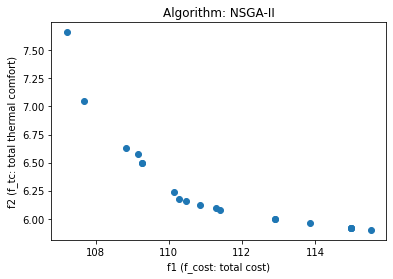

In [7]:
#Initialization : parameters
pop_size = 20
max_gen = 50
gen_no=0

# Input
occupant_total = 55
t = [22.75, 22.125, 24.562, 22.625, 23.187, 22.687, 23.125]

# Initialization : solutions
solution = np.zeros((pop_size, 7))

for i in range(0,pop_size):
    solution[i] = solutions_initialization(occupant_total)

while(gen_no<max_gen):
    
    # Parents
    
    ## fitness functions
    function1_values = [function1(solution[i])for i in range(0,pop_size)] 
    function2_values = [function2(solution[i],t)for i in range(0,pop_size)]
    
    ## fast_non_dominated_sort
    non_dominated_sorted_solution = fast_non_dominated_sort(function1_values[:],function2_values[:])
    print("The best front for Generation number ",gen_no+1, " is")
    
    ## min(fitness function) -> last values in non_dominated_sorted_solution
    for valuez in non_dominated_sorted_solution[0]:
        print(solution[valuez],' f1:',function1(solution[valuez]),' f2: ',function2(solution[valuez],t))
    print("\n")
    
    ## crowding_distance
    crowding_distance_values=[]
    for i in range(0,len(non_dominated_sorted_solution)):
        crowding_distance_values.append(crowding_distance(function1_values[:],function2_values[:],non_dominated_sorted_solution[i][:]))
    
    
    # Generating offsprings
    
    ## solutions and fitness functions: parents + offsprings
    solution2 = np.tile(solution, (2,1))
    
    for i in range(0,pop_size):
        a1 = random.randint(0,pop_size-1)
        solution2[pop_size+i] = mutation(solution[a1])
         
    ## fitness functions
    function1_values2 = [function1(solution2[i])for i in range(0,2*pop_size)]
    function2_values2 = [function2(solution2[i],t)for i in range(0,2*pop_size)]
    
    ## fast_non_dominated_sort
    non_dominated_sorted_solution2 = fast_non_dominated_sort(function1_values2[:],function2_values2[:])
    
    ## crowding_distance
    crowding_distance_values2=[]
    for i in range(0,len(non_dominated_sorted_solution2)):
        crowding_distance_values2.append(crowding_distance(function1_values2[:],function2_values2[:],non_dominated_sorted_solution2[i][:]))
    
    new_solution= []
    for i in range(0,len(non_dominated_sorted_solution2)):
        non_dominated_sorted_solution2_1 = [index_of(non_dominated_sorted_solution2[i][j],non_dominated_sorted_solution2[i] ) for j in range(0,len(non_dominated_sorted_solution2[i]))]
        front22 = sort_by_values(non_dominated_sorted_solution2_1[:], crowding_distance_values2[i][:])
        front = [non_dominated_sorted_solution2[i][front22[j]] for j in range(0,len(non_dominated_sorted_solution2[i]))]
        front.reverse()
        for value in front:
            new_solution.append(value)
            if(len(new_solution)==pop_size):
                break
        if (len(new_solution) == pop_size):
            break
    
    ## final solutions in this generation
    solution = [solution2[i] for i in new_solution]
    gen_no = gen_no + 1


    
#print('solution\n',solution) 
#print('function1_values\n',function1_values)   
#print('function2_values\n',function2_values)

#Lets plot the final front now
function1 = [i * -1 for i in function1_values]
function2 = [j * -1 for j in function2_values]
plt.xlabel('f1 (f_cost: total cost)')
plt.ylabel('f2 (f_tc: total thermal comfort)')
plt.scatter(function1, function2)
plt.title('Algorithm: NSGA-II')
plt.show()